In [3]:
!pip install pycocotools ultralytics ipywidgets -q

In [4]:
import os
import json
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
import cv2
import yaml
import torch

In [5]:
def create_dataset_directories(base_path):
    """Create necessary directories for YOLO format"""
    dirs = ['images/train', 'images/val', 'labels/train', 'labels/val']
    for dir_path in dirs:
        os.makedirs(os.path.join(base_path, dir_path), exist_ok=True)
        print(f"Created directory: {os.path.join(base_path, dir_path)}")

def convert_bbox_coco_to_yolo(bbox, img_width, img_height):
    """Convert COCO format bbox to YOLO format"""
    x, y, width, height = bbox
    
    # Normalize coordinates
    x_center = (x + width/2) / img_width
    y_center = (y + height/2) / img_height
    norm_width = width / img_width
    norm_height = height / img_height
    
    return [x_center, y_center, norm_width, norm_height]

def prepare_taco_dataset(annotations_path, data_dir, output_path, val_split=0.2):
    """Prepare TACO dataset in YOLO format"""
    print(f"Loading annotations from: {annotations_path}")
    
    # Load annotations directly from JSON file
    with open(annotations_path, 'r') as f:
        annotation_data = json.load(f)
    
    # Create directories
    create_dataset_directories(output_path)
    
    # Create category mapping
    categories = {cat['id']: idx for idx, cat in enumerate(annotation_data['categories'])}
    category_names = [cat['name'] for cat in annotation_data['categories']]
    
    print(f"Found {len(categories)} categories: {category_names}")
    
    # Create image ID to filename mapping
    image_info = {img['id']: img for img in annotation_data['images']}
    
    # Group annotations by image_id
    annotations_by_image = {}
    for ann in annotation_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)
    
    # Split images into train and val sets
    image_ids = list(image_info.keys())
    train_ids, val_ids = train_test_split(image_ids, test_size=val_split, random_state=42)
    
    def process_split(image_ids, split_name):
        processed = 0
        skipped = 0
        
        for image_id in tqdm(image_ids, desc=f"Processing {split_name} set"):
            img_data = image_info[image_id]
            src_path = os.path.join(data_dir, img_data['file_name'])
            
            if not os.path.exists(src_path):
                print(f"Warning: Image not found: {src_path}")
                skipped += 1
                continue
                
            # Copy image
            dest_img_path = os.path.join(output_path, 'images', split_name, os.path.basename(img_data['file_name']))
            shutil.copy(src_path, dest_img_path)
            
            # Create label file
            label_filename = os.path.splitext(os.path.basename(img_data['file_name']))[0] + '.txt'
            label_path = os.path.join(output_path, 'labels', split_name, label_filename)
            
            if image_id in annotations_by_image:
                with open(label_path, 'w') as f:
                    for ann in annotations_by_image[image_id]:
                        category_idx = categories[ann['category_id']]
                        bbox = convert_bbox_coco_to_yolo(
                            ann['bbox'],
                            img_data['width'],
                            img_data['height']
                        )
                        f.write(f"{category_idx} {' '.join([f'{x:.6f}' for x in bbox])}\n")
            
            processed += 1
        
        return processed, skipped
    
    # Process both splits
    train_processed, train_skipped = process_split(train_ids, 'train')
    val_processed, val_skipped = process_split(val_ids, 'val')
    
    print(f"\nDataset preparation completed:")
    print(f"Train set: {train_processed} processed, {train_skipped} skipped")
    print(f"Val set: {val_processed} processed, {val_skipped} skipped")
    
    # Create YAML configuration file
    yaml_content = {
        'path': os.path.abspath(output_path),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(categories),
        'names': category_names
    }
    
    yaml_path = os.path.join(output_path, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)
    
    print(f"\nDataset configuration saved to: {yaml_path}")
    return yaml_path

def train_yolov8(yaml_path, epochs=100, img_size=640, batch_size=16):
    """Train YOLOv8 model"""
    from ultralytics import YOLO
    
    print("\nInitializing YOLOv8 training...")
    print(f"Training configuration:")
    print(f"- Epochs: {epochs}")
    print(f"- Image size: {img_size}")
    print(f"- Batch size: {batch_size}")
    print(f"- Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    
    # Load a YOLOv8 model
    model = YOLO('yolov8n.pt')  # Load YOLOv8 nano model
    
    # Train the model
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        patience=50,  # Early stopping patience
        save=True,  # Save checkpoints
        device='0' if torch.cuda.is_available() else 'cpu'
    )
    
    return results


In [6]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from datetime import datetime

def plot_training_results(results, save_dir):
    """Plot and save training metrics"""
    metrics = ['box_loss', 'cls_loss', 'dfl_loss']
    
    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        plt.plot(results.results_dict[metric], label=f'Train {metric}')
        plt.plot(results.results_dict[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'{metric} over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_losses.png'))
    plt.close()
    
    # Plot metrics
    metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 4, i)
        plt.plot(results.results_dict[metric], label=metric.split('/')[-1])
        plt.title(f'{metric.split("/")[-1]} over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_metrics.png'))
    plt.close()

def run_inference(model_path, image_path, conf_threshold=0.25, save_dir='results'):
    """Run inference on a single image or directory of images"""
    # Load the trained model
    model = YOLO(model_path)
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Run inference on single image or directory
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=True,
        save_txt=True,
        save_conf=True,
        project=save_dir,
        name=f'predict_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    )
    
    return results

def analyze_results(results, save_dir):
    """Analyze and save detection statistics"""
    all_classes = []
    all_confidences = []
    
    for result in results:
        if result.boxes.cls.numel() > 0:
            all_classes.extend(result.boxes.cls.cpu().numpy())
            all_confidences.extend(result.boxes.conf.cpu().numpy())
    
    if not all_classes:
        print("No detections found!")
        return
    
    # Convert to numpy arrays
    all_classes = np.array(all_classes)
    all_confidences = np.array(all_confidences)
    
    # Plot class distribution
    plt.figure(figsize=(10, 6))
    unique_classes, counts = np.unique(all_classes, return_counts=True)
    plt.bar([str(int(c)) for c in unique_classes], counts)
    plt.title('Distribution of Detected Classes')
    plt.xlabel('Class ID')
    plt.ylabel('Count')
    plt.savefig(os.path.join(save_dir, 'class_distribution.png'))
    plt.close()
    
    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(all_confidences, bins=20)
    plt.title('Distribution of Detection Confidences')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.savefig(os.path.join(save_dir, 'confidence_distribution.png'))
    plt.close()
    
    # Save statistics to text file
    with open(os.path.join(save_dir, 'detection_stats.txt'), 'w') as f:
        f.write("Detection Statistics:\n\n")
        f.write(f"Total detections: {len(all_classes)}\n")
        f.write(f"Unique classes detected: {len(unique_classes)}\n")
        f.write(f"Average confidence: {all_confidences.mean():.3f}\n")
        f.write("\nClass distribution:\n")
        for cls, count in zip(unique_classes, counts):
            f.write(f"Class {int(cls)}: {count} detections\n")

def evaluate_model(model_path, test_dir, save_dir='evaluation'):
    """Evaluate model performance on a test set"""
    model = YOLO(model_path)
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Run validation on test directory
    results = model.val(
        data=test_dir,
        save_json=True,
        save_hybrid=True,
        project=save_dir,
        name=f'val_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    )
    
    return results


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from datetime import datetime

def plot_training_results(trainer, save_dir):
    """Plot and save training metrics"""
    results_dict = trainer.results_dict
    
    # Plot training and validation metrics
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    
    # Training Loss Plot
    ax[0, 0].plot(results_dict['train/box_loss'], label='train')
    ax[0, 0].plot(results_dict['val/box_loss'], label='val')
    ax[0, 0].set_title('Box Loss')
    ax[0, 0].set_xlabel('epoch')
    ax[0, 0].set_ylabel('loss')
    ax[0, 0].legend()
    
    # Classification Loss Plot
    ax[0, 1].plot(results_dict['train/cls_loss'], label='train')
    ax[0, 1].plot(results_dict['val/cls_loss'], label='val')
    ax[0, 1].set_title('Classification Loss')
    ax[0, 1].set_xlabel('epoch')
    ax[0, 1].set_ylabel('loss')
    ax[0, 1].legend()
    
    # mAP Plot
    ax[1, 0].plot(results_dict['metrics/mAP50(B)'], label='mAP50')
    ax[1, 0].plot(results_dict['metrics/mAP50-95(B)'], label='mAP50-95')
    ax[1, 0].set_title('Mean Average Precision')
    ax[1, 0].set_xlabel('epoch')
    ax[1, 0].set_ylabel('mAP')
    ax[1, 0].legend()
    
    # Precision-Recall Plot
    ax[1, 1].plot(results_dict['metrics/precision(B)'], label='precision')
    ax[1, 1].plot(results_dict['metrics/recall(B)'], label='recall')
    ax[1, 1].set_title('Precision and Recall')
    ax[1, 1].set_xlabel('epoch')
    ax[1, 1].set_ylabel('value')
    ax[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_metrics.png'))
    plt.close()

def run_inference(model_path, image_path, conf_threshold=0.25, save_dir='results'):
    """Run inference on a single image or directory of images"""
    model = YOLO(model_path)
    
    os.makedirs(save_dir, exist_ok=True)
    
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=True,
        save_txt=True,
        save_conf=True,
        project=save_dir,
        name=f'predict_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    )
    
    return results

def analyze_results(results, save_dir):
    """Analyze and save detection statistics"""
    class_counts = {}
    confidences = []
    
    # Process all results
    for r in results:
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls.item())
            conf = float(box.conf.item())
            
            if cls not in class_counts:
                class_counts[cls] = 0
            class_counts[cls] += 1
            confidences.append(conf)
    
    if not confidences:
        print("No detections found!")
        return
    
    # Plot class distribution
    plt.figure(figsize=(10, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.bar(classes, counts)
    plt.title('Distribution of Detected Classes')
    plt.xlabel('Class ID')
    plt.ylabel('Count')
    plt.savefig(os.path.join(save_dir, 'class_distribution.png'))
    plt.close()
    
    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(confidences, bins=20)
    plt.title('Distribution of Detection Confidences')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.savefig(os.path.join(save_dir, 'confidence_distribution.png'))
    plt.close()
    
    # Save statistics
    with open(os.path.join(save_dir, 'detection_stats.txt'), 'w') as f:
        f.write("Detection Statistics:\n\n")
        f.write(f"Total detections: {sum(counts)}\n")
        f.write(f"Unique classes detected: {len(classes)}\n")
        f.write(f"Average confidence: {np.mean(confidences):.3f}\n\n")
        f.write("Class distribution:\n")
        for cls, count in class_counts.items():
            f.write(f"Class {cls}: {count} detections\n")

def run_complete_pipeline(data_config, epochs=100, img_size=640, batch_size=16):
    """Run complete training and evaluation pipeline"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_dir = f"yolo_results_{timestamp}"
    results_dir = os.path.join(base_dir, "results")
    model_dir = os.path.join(base_dir, "models")
    
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    
    # Train model
    print("\nStarting training...")
    model = YOLO('yolov8n.pt')
    trainer = model.train(
        data=data_config,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        patience=50,
        save=True,
        device='0' if torch.cuda.is_available() else 'cpu',
        project=model_dir,
        name=f'train_{timestamp}'
    )
    
    # Plot and save training results
    print("\nSaving training plots...")
    # plot_training_results(trainer, results_dir)
    
    # Get best model path
    best_model_path = os.path.join(model_dir, f"train_{timestamp}", "weights", "best.pt")
    
    # # Run inference on validation set
    # print("\nRunning inference on validation set...")
    # val_dir = os.path.join(os.path.dirname(data_config), 'images/val')
    # inference_results = run_inference(
    #     model_path=best_model_path,
    #     image_path=val_dir,
    #     save_dir=os.path.join(results_dir, 'validation_predictions')
    # )
    
    # # Analyze results
    # print("\nAnalyzing detection results...")
    # analyze_results(inference_results, results_dir)
    
    print(f"\nAll results saved in: {base_dir}")
    return best_model_path, results_dir


In [8]:
# Set your paths
BASE_PATH = "/kaggle/input/tacotrashdataset"
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "data/annotations.json")
DATA_DIR = os.path.join(BASE_PATH, "data")
OUTPUT_PATH = os.path.join("/kaggle/working", "yolo_dataset")

In [9]:
# Prepare dataset
yaml_path = prepare_taco_dataset(
    annotations_path=ANNOTATIONS_PATH,
    data_dir=DATA_DIR,
    output_path=OUTPUT_PATH
)

Loading annotations from: /kaggle/input/tacotrashdataset/data/annotations.json
Created directory: /kaggle/working/yolo_dataset/images/train
Created directory: /kaggle/working/yolo_dataset/images/val
Created directory: /kaggle/working/yolo_dataset/labels/train
Created directory: /kaggle/working/yolo_dataset/labels/val
Found 60 categories: ['Aluminium foil', 'Battery', 'Aluminium blister pack', 'Carded blister pack', 'Other plastic bottle', 'Clear plastic bottle', 'Glass bottle', 'Plastic bottle cap', 'Metal bottle cap', 'Broken glass', 'Food Can', 'Aerosol', 'Drink can', 'Toilet tube', 'Other carton', 'Egg carton', 'Drink carton', 'Corrugated carton', 'Meal carton', 'Pizza box', 'Paper cup', 'Disposable plastic cup', 'Foam cup', 'Glass cup', 'Other plastic cup', 'Food waste', 'Glass jar', 'Plastic lid', 'Metal lid', 'Other plastic', 'Magazine paper', 'Tissues', 'Wrapping paper', 'Normal paper', 'Paper bag', 'Plastified paper bag', 'Plastic film', 'Six pack rings', 'Garbage bag', 'Other 

Processing val set: 100%|██████████| 300/300 [00:07<00:00, 40.30it/s]


Dataset preparation completed:
Train set: 1200 processed, 0 skipped
Val set: 300 processed, 0 skipped

Dataset configuration saved to: /kaggle/working/yolo_dataset/dataset.yaml



Starting training...
Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset/dataset.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolo_results_20241124_112722/models, name=train_20241124_112722, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

train: Scanning /kaggle/working/yolo_dataset/labels/train.cache... 316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 316/316 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 182 images, 0 backgrounds, 0 corrupt: 100%|██████████| 182/182 [00:00<?, ?it/s]


Plotting labels to yolo_results_20241124_112722/models/train_20241124_112722/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000156, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to yolo_results_20241124_112722/models/train_20241124_112722
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.64G      1.577      5.608       1.49         59        640: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all        182        476          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.47G      1.467       5.46      1.423         44        640: 100%|██████████| 20/20 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]

                   all        182        476          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.51G      1.471      5.244      1.434         38        640: 100%|██████████| 20/20 [00:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.77it/s]

                   all        182        476          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.52G      1.536      5.132      1.492         66        640: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all        182        476    0.00761     0.0769     0.0136     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.57G       1.56      4.946      1.475         45        640: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        182        476       0.58     0.0409      0.021     0.0179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.51G      1.548      4.772      1.476         70        640: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


                   all        182        476      0.593     0.0527     0.0245     0.0212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.52G      1.536      4.701      1.442         93        640: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


                   all        182        476      0.523     0.0546     0.0262     0.0224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.49G      1.528      4.534      1.429         67        640: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

                   all        182        476      0.494     0.0327     0.0268     0.0215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.49G      1.515      4.526      1.448         72        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


                   all        182        476      0.473     0.0398     0.0339     0.0288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.49G      1.505      4.448      1.439         66        640: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

                   all        182        476      0.457     0.0616     0.0521     0.0449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.49G      1.412      4.208      1.366        106        640: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        182        476      0.415     0.0689     0.0445     0.0374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.49G      1.434      4.218      1.408         39        640: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        182        476      0.349     0.0478     0.0456     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.55G      1.392      3.977      1.354         49        640: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        182        476      0.359     0.0587     0.0458     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.52G       1.37      4.073      1.367         60        640: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        182        476      0.363     0.0599     0.0493     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.53G      1.515      4.126      1.437        105        640: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

                   all        182        476      0.367     0.0487     0.0507     0.0436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.53G      1.443      3.939      1.371         81        640: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        182        476      0.321     0.0404     0.0477       0.04



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.52G      1.444      3.924      1.387         53        640: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all        182        476      0.307     0.0882     0.0422     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.5G      1.368       3.83       1.35         36        640: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        182        476      0.262     0.0753     0.0409     0.0325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.51G      1.424      3.763      1.357         65        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

                   all        182        476      0.383     0.0852     0.0466     0.0357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.52G      1.368      3.722      1.338         37        640: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

                   all        182        476      0.369       0.11     0.0636     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.49G      1.476      3.791      1.408         70        640: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        182        476      0.308      0.121     0.0564     0.0421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.53G       1.38      3.488      1.309         68        640: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


                   all        182        476      0.296     0.0895      0.054     0.0428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.53G      1.351      3.463      1.322         57        640: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

                   all        182        476      0.365     0.0676     0.0544     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.55G      1.383      3.618      1.321         50        640: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        182        476      0.412     0.0904     0.0579     0.0452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.51G      1.397      3.553      1.343         80        640: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

                   all        182        476      0.356     0.0977      0.053     0.0425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.53G      1.426      3.417      1.378         59        640: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        182        476      0.354     0.0894      0.056     0.0453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.53G      1.326      3.293      1.316         59        640: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        182        476      0.557     0.0696     0.0536     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.51G      1.346      3.309      1.313         84        640: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


                   all        182        476       0.27     0.0885     0.0539     0.0446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.54G       1.21      3.111      1.241         80        640: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        182        476      0.261     0.0818     0.0579     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.5G       1.36      3.301      1.288         32        640: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        182        476      0.299     0.0931     0.0642      0.053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.51G      1.317      3.259      1.332         51        640: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]

                   all        182        476       0.35      0.102     0.0683     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.55G      1.281      3.258      1.297         39        640: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        182        476      0.301      0.099     0.0654     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.49G      1.327      3.259      1.313         35        640: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all        182        476      0.227      0.105     0.0707     0.0578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.49G       1.31      3.148      1.271         72        640: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]


                   all        182        476      0.283      0.108     0.0695     0.0567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.5G      1.288      3.137      1.279         34        640: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        182        476      0.366     0.0939     0.0689     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.53G       1.36      3.085       1.31         86        640: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


                   all        182        476      0.488     0.0517     0.0677      0.056

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.51G      1.287       3.14       1.33         49        640: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        182        476      0.225     0.0957     0.0637     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.54G      1.272      2.947      1.283         52        640: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        182        476      0.266     0.0905     0.0681     0.0559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.51G       1.32      3.096       1.31         58        640: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]

                   all        182        476      0.394     0.0705     0.0707     0.0555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.49G      1.185      2.871      1.218         63        640: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


                   all        182        476      0.259     0.0884     0.0638     0.0505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.51G       1.28      2.891      1.291         42        640: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


                   all        182        476      0.303     0.0964     0.0705     0.0543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.49G      1.231      2.897      1.245         45        640: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        182        476      0.265     0.0903     0.0703     0.0531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.54G      1.251      2.872       1.25         40        640: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

                   all        182        476      0.201     0.0751     0.0683     0.0542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.48G      1.174      2.783      1.217         60        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        182        476      0.218     0.0768     0.0639     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.55G       1.29      2.861      1.254         45        640: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


                   all        182        476      0.231     0.0839     0.0708     0.0553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.49G      1.139      2.641      1.206         64        640: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        182        476      0.185      0.111     0.0689     0.0548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.49G      1.217      2.772      1.224         45        640: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

                   all        182        476      0.208       0.11      0.067     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.53G      1.201      2.765      1.222         38        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        182        476      0.205     0.0919     0.0681     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.49G      1.184      2.603      1.197         68        640: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

                   all        182        476      0.165      0.102      0.069      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.5G      1.237      2.816      1.254         33        640: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


                   all        182        476      0.215      0.126     0.0681     0.0542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.51G      1.182      2.587      1.222         55        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]

                   all        182        476      0.213      0.107     0.0693     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.49G      1.152      2.711      1.222         43        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]

                   all        182        476      0.195      0.101     0.0701     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.48G      1.197      2.584       1.21         66        640: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

                   all        182        476      0.217     0.0865     0.0675     0.0542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.53G      1.275      2.637      1.275         89        640: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all        182        476      0.232     0.0843     0.0657     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.53G      1.221      2.613      1.238         62        640: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


                   all        182        476      0.243     0.0973     0.0704     0.0583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.52G      1.138      2.486      1.176         58        640: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

                   all        182        476      0.289      0.104     0.0684     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.49G      1.139      2.502      1.167         71        640: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all        182        476      0.263      0.104     0.0693      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.49G      1.195      2.591      1.207         69        640: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


                   all        182        476      0.277     0.0925     0.0724      0.059

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.55G       1.15      2.449      1.187         56        640: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

                   all        182        476      0.299     0.0899     0.0705     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.49G      1.132      2.429       1.16         66        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


                   all        182        476      0.211      0.099     0.0731     0.0578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.49G      1.209      2.533      1.219         57        640: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


                   all        182        476      0.217     0.0721      0.068     0.0537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.5G      1.203      2.572      1.197         66        640: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

                   all        182        476      0.277     0.0749     0.0664     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.46G      1.119      2.546      1.195         79        640: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


                   all        182        476      0.263       0.11     0.0675     0.0521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.49G      1.108      2.348      1.167         74        640: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

                   all        182        476      0.182      0.109      0.061     0.0467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.49G      1.087      2.289       1.13         82        640: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

                   all        182        476      0.182      0.106     0.0633     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.51G      1.099      2.334      1.169         64        640: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all        182        476      0.158      0.113     0.0707     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.53G      1.101      2.346      1.169         47        640: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

                   all        182        476      0.172     0.0986     0.0717      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.49G      1.134      2.326       1.17         73        640: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        182        476      0.198     0.0891     0.0666     0.0531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.53G      1.056      2.293      1.132         43        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        182        476      0.169     0.0826     0.0668     0.0531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.51G      1.077      2.362      1.141         41        640: 100%|██████████| 20/20 [00:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

                   all        182        476      0.207     0.0796     0.0681     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.49G      1.027      2.178      1.141         72        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


                   all        182        476      0.185     0.0883     0.0688     0.0573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.48G       1.18      2.412      1.214         49        640: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


                   all        182        476      0.211      0.107     0.0686     0.0571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.49G       1.09      2.236      1.176         41        640: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

                   all        182        476      0.158      0.106     0.0687     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.55G      1.077      2.209      1.146         73        640: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        182        476      0.188      0.118     0.0697     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.54G      1.068      2.281      1.146         91        640: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

                   all        182        476      0.187      0.129     0.0705     0.0577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.52G      1.106      2.314      1.154         84        640: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


                   all        182        476      0.186      0.104     0.0704     0.0576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.5G      1.115      2.336      1.191         76        640: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        182        476      0.196     0.0919     0.0662     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.49G      1.109      2.415      1.165         43        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


                   all        182        476      0.251     0.0838     0.0689     0.0563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.51G      1.111      2.432      1.189         34        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        182        476      0.266      0.101       0.07     0.0577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.49G      1.098      2.257       1.14         61        640: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        182        476      0.264      0.106     0.0698     0.0581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.52G      1.098      2.259      1.154         48        640: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


                   all        182        476      0.239      0.107     0.0666     0.0543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.49G      1.106      2.254      1.187         42        640: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        182        476      0.216      0.116     0.0644     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.52G      1.079      2.218      1.153         75        640: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        182        476      0.219      0.115     0.0658     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.52G      1.043       2.14      1.132         53        640: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


                   all        182        476      0.214      0.103     0.0703      0.057

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.51G      1.094       2.31      1.171         55        640: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        182        476      0.235     0.0942     0.0722     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.51G       1.05      2.173      1.144         54        640: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        182        476       0.21      0.096     0.0694     0.0558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.54G      1.086      2.281      1.178         48        640: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


                   all        182        476      0.237     0.0979     0.0704     0.0573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.51G      1.095      2.237       1.16         48        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all        182        476      0.236     0.0999     0.0715     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.49G       1.06      2.172      1.135         84        640: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        182        476      0.266     0.0985     0.0719     0.0603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.49G      1.048      2.186       1.15         59        640: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        182        476      0.312     0.0912      0.076      0.064


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.46G      1.102      2.581      1.177         45        640: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


                   all        182        476      0.291      0.119     0.0747     0.0625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.49G      1.066      2.555       1.17         48        640: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

                   all        182        476      0.247      0.117     0.0732     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.52G      1.099      2.616      1.167         32        640: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        182        476      0.306      0.112     0.0735     0.0608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.49G      1.033      2.484      1.139         38        640: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all        182        476      0.332      0.111     0.0758     0.0624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.46G      1.028      2.465      1.137         23        640: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        182        476      0.304      0.093     0.0744      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.46G      1.027      2.516      1.139         50        640: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all        182        476      0.303      0.108     0.0754     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.48G      1.043      2.486      1.155         36        640: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


                   all        182        476      0.301      0.105     0.0752     0.0615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.49G       1.03      2.448      1.136         24        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


                   all        182        476      0.299      0.104      0.074     0.0616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.46G      1.024       2.42      1.124         28        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        182        476      0.302     0.0973     0.0749     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.49G      1.019      2.452      1.141         38        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


                   all        182        476        0.3      0.113     0.0747     0.0616

100 epochs completed in 0.322 hours.
Optimizer stripped from yolo_results_20241124_112722/models/train_20241124_112722/weights/last.pt, 6.3MB
Optimizer stripped from yolo_results_20241124_112722/models/train_20241124_112722/weights/best.pt, 6.3MB

Validating yolo_results_20241124_112722/models/train_20241124_112722/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,017,348 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


                   all        182        476      0.312     0.0909     0.0759      0.064
        Aluminium foil          5          6          0          0    0.00651     0.0039
   Carded blister pack          1          1          0          0          0          0
  Other plastic bottle         11         13      0.258      0.154      0.174      0.161
  Clear plastic bottle         25         29      0.345      0.414      0.267      0.216
          Glass bottle          5          7          0          0          0          0
    Plastic bottle cap         29         29      0.135     0.0345     0.0591     0.0337
              Food Can          1          2          0          0     0.0686     0.0229
               Aerosol          2          2          1          0     0.0422     0.0422
             Drink can         13         17     0.0756      0.118     0.0266       0.02
           Toilet tube          1          1          0          0          0          0
          Other carto

KeyError: 'train/box_loss'

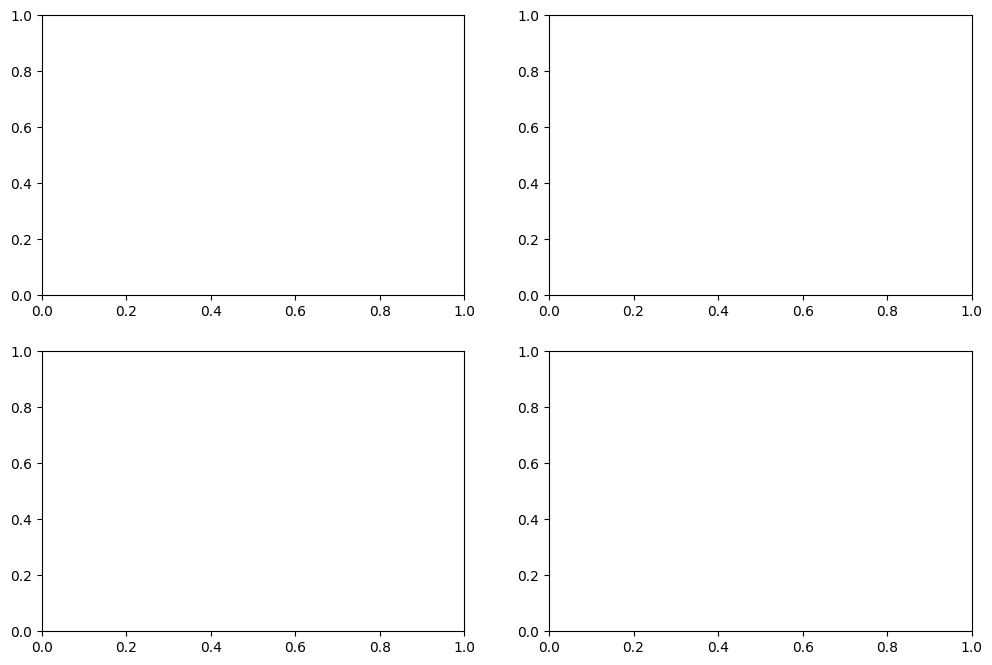

In [13]:
# Run complete pipeline
best_model_path, results_dir = run_complete_pipeline(
    data_config=yaml_path,
    epochs=100,
    img_size=640,
    batch_size=16
)

In [ ]:
print("Training and evaluation completed!")
print(f"Best model saved at: {best_model_path}")
print(f"Results saved at: {results_dir}")

In [ ]:
/kaggle/working/yolo_results_20241124_112722

In [14]:
import zipfile
import os

# Define the folder to be zipped
folder_to_zip = '/kaggle/working/yolo_results_20241124_112722'
output_zip = '/kaggle/working/yolo_results_20241124_112722.zip'

# Create a ZIP file
with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            # Get the file path
            file_path = os.path.join(root, file)
            # Add file to the ZIP, keeping the folder structure
            arcname = os.path.relpath(file_path, folder_to_zip)
            zipf.write(file_path, arcname)

print(f"ZIP file created at: {output_zip}")


ZIP file created at: /kaggle/working/yolo_results_20241124_112722.zip
